## Generating and testing a hypothesis

Purpose: We want to assess the correlation of structure (e.g. lipophilicity) of some molecules with their inhibitory activity for Acetylcholinesterase (AChE). 

We have already seen that the correlation doesn't seem to be too strong, but is it statistically significant? Hence our hypothesis is still: "High lipohilicity (XlogP) leads to higher potency (pchembl_value)".

Import dependencies and load the combined dataset for assessing our "quantitative structure-activity relationship" (QSAR).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load both datasets
df = pd.read_csv("ache_qsar_data.csv")
df.head()



,Unnamed: 0,canonical_smiles,pchembl_value,CID,MolecularWeight,XLogP,TPSA,HBondDonorCount,HBondAcceptorCount,RotatableBondCount
0,1,C(=C/C1CCN(Cc2ccccc2)CC1)\c1noc2ccccc12,6.68,9901561,318.4,4.5,29.3,0,3.0,4
1,2,C/C=C1\[C@H]2C=C(C)C[C@]1(NC1OCC3=C4CC(C)(C)C[...,6.96,118715261,492.6,1.2,90.8,4,5.0,2
2,3,C/C=C1\[C@H]2C=C(C)C[C@]1(N[C@H]1OC(=O)C3=C4CC...,5.66,118715260,506.6,1.5,108.0,4,6.0,2
3,4,C=CC(=O)N1C/C(=C\c2ccc(C)cc2)C(=O)/C(=C/c2ccc(...,4.74,24796898,357.4,4.4,37.4,0,2.0,3
4,5,C=CC(=O)N1C/C(=C\c2ccc(Cl)cc2Cl)C(=O)/C(=C/c2c...,4.80,71720637,467.2,6.2,37.4,0,2.0,3


Produce a scatterplot of the columns "XLogP" and "pchembl_value".

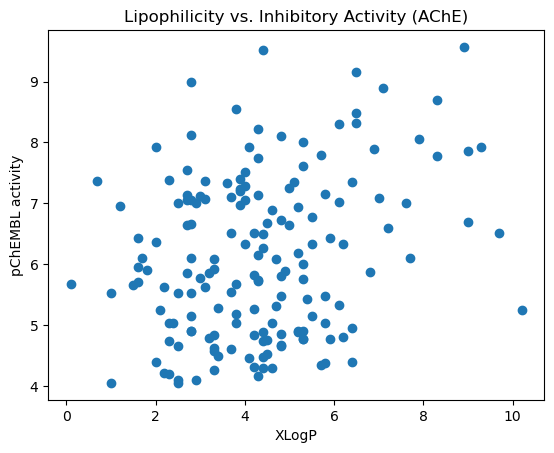

In [3]:
# Quick scatter plot
plt.scatter(df["XLogP"], df["pchembl_value"])
plt.xlabel("XLogP")
plt.ylabel("pChEMBL activity")
plt.title("Lipophilicity vs. Inhibitory Activity (AChE)")
plt.show()


To test our hypothesis, we will have a look at highly lipophilic molecules and compare them to the rest. The null-hypothesis is that for both groups, the mean will be the same (mean_low = mean_high).

First, let's create a new column "high_logp" with the condition to XLogP > 3 to start with.

In [ ]:
# Define high/low lipophilicity groups
df["high_logp"] = df["XLogP"] > 5
df.head()


Now, calculate the means for all low_logp and high_logp molecules. For this, use the "high_logp" column to create two groups. Compare their size and their variance.

Now, run a two-sample t-test to assess our null-hypothesis ("the means of the two groups are equal"). If the p_value is lower than 0.05, we can reject the null-hypothesis and our alternative hypothesis is true, i.e. there is a significant difference between the two means (which tells us that the higher lipophilicity leads to increased activity).

In [ ]:
# t-test

t_value, p_value = stats.ttest_ind(group_high, group_low, equal_var=False, nan_policy="omit")
print(f"t_value = {t_value:.2f}, p_value = {p_value:.4f}")